In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import combinations
from scipy.stats import kendalltau
from batchlog import BatchLogistic

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rc
plt.style.use('seaborn')
rc('text', usetex=True)
%matplotlib inline

## Import scores from CSV

In [7]:
male_scores = pd.read_csv('scores/trimmed_male.csv')
female_scores = pd.read_csv('scores/trimmed_female.csv')

## Split data into train and test

In [4]:
years_before_last = range(2005, 2018)
year_seed = np.random.RandomState(seed=42)
train_years = sorted(list(year_seed.choice(years_before_last, size=10, replace=False)))
test_years = sorted([year for year in years_before_last if year not in train_years] + [2018])
train_years, test_years

([2005, 2006, 2007, 2009, 2010, 2012, 2013, 2014, 2016, 2017],
 [2008, 2011, 2015, 2018])

In [5]:
def train_test_split(scores, train_years, test_years):
    season_scores = scores.loc[scores['event']!='WR']
    world_scores = scores.loc[scores['event']=='WR']
    
    season_train = season_scores.loc[season_scores['year'].isin(train_years)]
    world_train = world_scores.loc[world_scores['year'].isin(train_years)]
    season_test = season_scores.loc[season_scores['year'].isin(test_years)]
    world_test = world_scores.loc[world_scores['year'].isin(test_years)]    
    
    return season_train, world_train, season_test, world_test

In [8]:
season_train, world_train, season_test, world_test = train_test_split(male_scores, train_years, test_years)
season_train.shape, world_train.shape, season_test.shape, world_test.shape

((1216, 4), (238, 4), (507, 4), (96, 4))

## Implement kendall tau metrics

In [9]:
def return_ranking(skater_scores, world_scores):
    skater_scores = skater_scores.sort_values(ascending=False)
    world_scores = world_scores.sort_values(ascending=False)
    skater_ranking = list(skater_scores.index.intersection(world_scores.index))
    world_ranking = list(world_scores.index.intersection(skater_scores.index))
    return skater_ranking, world_ranking

In [10]:
def calculate_kendall_tau(skater_ranking, world_ranking, verbose=True):
    skater_pairs = set(combinations(skater_ranking, 2))
    world_pairs = set(combinations(world_ranking, 2))
    n_pairs = len(skater_pairs)
    n_concordant_pairs = len(set(skater_pairs) & set(world_pairs))
    print(f'There are {n_concordant_pairs} concordant_pairs out of {n_pairs} pairs')
    tau = (2 * n_concordant_pairs - n_pairs) / n_pairs
    return tau 

## Average skate score model

In [11]:
year = 2017
season_scores = season_train.loc[season_train['year']==year].copy()
world_scores = world_train.loc[world_train['year']==year, ['name', 'score']].set_index('name').squeeze()

In [14]:
season_avg = season_scores.groupby('name')['score'].mean().sort_values(ascending=False)
season_avg.head()

name
Yuzuru, HANYU        290.5350
Javier, FERNANDEZ    285.4925
Shoma, UNO           283.7425
Nathan, CHEN         281.0050
Patrick, CHAN        270.3500
Name: score, dtype: float64

In [15]:
avg_ranking, world_ranking = return_ranking(season_avg, world_scores)
calculate_kendall_tau(avg_ranking, world_ranking)

There are 234 concordant_pairs out of 276 pairs


0.6956521739130435

Result agrees with kendalltau from scipy

In [16]:
season_numeric_rank = list(range(len(avg_ranking)))
world_numeric_rank = [avg_ranking.index(skater) for skater in world_ranking]
kendalltau(season_numeric_rank, world_numeric_rank)

KendalltauResult(correlation=0.6956521739130435, pvalue=1.9126097800691154e-06)

RMSE with mean model

In [17]:
score_comparison = pd.merge(season_scores, season_avg.to_frame(), left_on='name', right_index=True, suffixes=['', '_avg'])
score_comparison['sq_error'] = (score_comparison['score'] - score_comparison['score_avg'])**2
np.sqrt(score_comparison['sq_error'].mean())

10.271546837961868

### Refactored

In [18]:
def get_yearly_scores(year, season_scores, world_scores):
    yearly_season_scores = season_scores.loc[season_scores['year']==year].copy()
    yearly_world_scores = world_scores.loc[world_scores['year']==year, ['name', 'score']].set_index('name').squeeze()
    return yearly_season_scores, yearly_world_scores

In [19]:
class Model:
    def __init__(self):
        self.skater_scores = None
        self.model_ranking = None
        self.world_ranking = None
        self.predicted_season_scores = None
    
    def evaluate_rmse(self, season_scores):
        squared_errors = (season_scores['score'].values - self.predicted_season_scores)**2
        rmse = np.sqrt(squared_errors.mean())
        return rmse
        
    def evaluate_kendall_tau(self, world_scores, verbose=True):
        def return_ranking(skater_scores, world_scores):
            skater_scores = skater_scores.sort_values(ascending=False)
            world_scores = world_scores.sort_values(ascending=False)
            skater_ranking = list(skater_scores.index.intersection(world_scores.index))
            world_ranking = list(world_scores.index.intersection(skater_scores.index))
            return skater_ranking, world_ranking
    
        def calculate_kendall_tau(skater_ranking, world_ranking, verbose=verbose):
            skater_pairs = set(combinations(skater_ranking, 2))
            world_pairs = set(combinations(world_ranking, 2))
            n_pairs = len(skater_pairs)
            n_concordant_pairs = len(set(skater_pairs) & set(world_pairs))
            if verbose:
                print(f'There are {n_concordant_pairs} concordant_pairs out of {n_pairs} pairs')
            tau = (2 * n_concordant_pairs - n_pairs) / n_pairs
            return tau, n_concordant_pairs, n_pairs
        
        self.model_ranking, self.world_ranking = return_ranking(self.skater_scores, world_scores)
        return calculate_kendall_tau(self.model_ranking, self.world_ranking)
    
    def evaluate_over_years(self, years, season_df, world_df, **kwargs):
        taus = []
        rmses = []
        concordant_pairs = []
        n_pairs = []
        for year in years:
            season_scores, world_scores = get_yearly_scores(year, season_df, world_df)
            self.fit(season_scores, **kwargs)
            rmse = self.evaluate_rmse(season_scores)
            tau, concordant_pair, n_pair = self.evaluate_kendall_tau(world_scores, verbose=False)
            
            rmses.append(rmse)
            taus.append(tau)
            concordant_pairs.append(concordant_pair)
            n_pairs.append(n_pair)
        return pd.DataFrame({'year': years, 'rmse': rmses, 
                             'tau': taus, 'conc': concordant_pairs, 'pairs': n_pairs}).sort_values(by='year')

In [20]:
class AverageScore(Model):
    def __init__(self):
        super().__init__()
        
    def predict_season_scores(self, season_scores):
        self.predicted_season_scores = self.skater_scores.loc[season_scores['name']].values
    
    def fit(self, season_scores):
        self.skater_scores = season_scores.groupby('name')['score'].mean()
        self.skater_scores.sort_values(ascending=False, inplace=True)
        self.predict_season_scores(season_scores)        

In [21]:
avg = AverageScore()
avg_train_eval = avg.evaluate_over_years(train_years, season_train, world_train)
avg_train_eval

,year,rmse,tau,conc,pairs
0,2005,10.357050,0.647619,173,210
1,2006,9.749220,0.691700,214,253
2,2007,8.151442,0.630435,225,276
3,2009,8.557905,0.601449,221,276
4,2010,11.139947,0.714286,198,231
5,2012,9.424702,0.604743,203,253
6,2013,9.965307,0.604743,203,253
7,2014,10.563519,0.819048,191,210
8,2016,12.694622,0.695652,234,276
9,2017,10.271547,0.695652,234,276


## Normalized mean model

In [22]:
season_scores['score_normed'] = season_scores.groupby('event')['score'].transform(lambda score: (score - score.mean()) / score.std())

In [23]:
season_normed_avg = season_scores.groupby('name')['score_normed'].mean().sort_values(ascending=False)
season_normed_avg.head()

name
Yuzuru, HANYU        1.668135
Javier, FERNANDEZ    1.440927
Shoma, UNO           1.326910
Nathan, CHEN         1.104096
Patrick, CHAN        1.090843
Name: score_normed, dtype: float64

In [24]:
normed_avg_ranking, world_ranking = return_ranking(season_normed_avg, world_scores)
calculate_kendall_tau(normed_avg_ranking, world_ranking)

There are 222 concordant_pairs out of 276 pairs


0.6086956521739131

### Refactored

In [25]:
class NormedAverageScore(Model):
    def __init__(self):
        super().__init__()
    
    def predict_season_scores(self, season_scores, event_stds, event_means):
        self.predicted_season_scores = (self.skater_scores.loc[season_scores['name']] * event_stds + event_means).values
        
    def fit(self, season_scores):
        season_scores = season_scores.copy()
        event_means = season_scores.groupby('event')['score'].mean().loc[season_scores['event']].values
        event_stds = season_scores.groupby('event')['score'].std().loc[season_scores['event']].values
        season_scores['score_normed'] = (season_scores['score'] - event_means) / event_stds
        
        self.skater_scores = season_scores.groupby('name')['score_normed'].mean()
        self.skater_scores.sort_values(ascending=False, inplace=True)
        
        self.predict_season_scores(season_scores, event_stds, event_means)        

In [26]:
normavg = NormedAverageScore()
normavg_train_eval = normavg.evaluate_over_years(train_years, season_train, world_train)
normavg_train_eval

,year,rmse,tau,conc,pairs
0,2005,14.221490,0.580952,166,210
1,2006,12.650485,0.636364,207,253
2,2007,12.556444,0.630435,225,276
3,2009,14.067104,0.615942,223,276
4,2010,12.898410,0.593074,184,231
5,2012,12.437599,0.494071,189,253
6,2013,15.373393,0.494071,189,253
7,2014,15.685363,0.685714,177,210
8,2016,18.328151,0.615942,223,276
9,2017,15.921112,0.608696,222,276


## Linear model

In [27]:
year = 2017
season_scores = season_train.loc[season_train['year']==year].copy()
world_scores = world_train.loc[world_train['year']==year, ['name', 'score']].set_index('name').squeeze()

In [28]:
dummies = pd.get_dummies(season_scores[['name', 'event']], prefix=['', ''], prefix_sep='', drop_first=True)
unique_skaters = season_scores['name'].unique()
unique_events = season_scores['event'].unique()

dummies_skater_count = len(unique_skaters) - 1
dummies_skaters = dummies.columns[:dummies_skater_count]
dummies_events = dummies.columns[dummies_skater_count:]

dropped_skater = list(set(unique_skaters) - set(dummies_skaters))[0]
dropped_event = list(set(unique_events) - set(dummies_events))[0]

In [29]:
X = dummies.values
X = np.insert(X, 0, 1, axis=1)
y = season_scores['score'].values
coefs_linear = np.linalg.inv(X.T @ X) @ (X.T @ y)
coefs_linear[:10]

array([ 262.83064921,  -58.77196129,  -27.74060019,  -38.56497213,
        -16.6525816 , -100.78064921,  -36.58476179,    3.9048582 ,
        -45.88750626,  -35.41149857])

In [30]:
linear_rmse = np.sqrt(np.mean((y - X @ coefs_linear)**2))
linear_rmse

8.838699611397724

Double check with sklearn's LinearRegression and mean_square_error

In [31]:
lin = LinearRegression(fit_intercept=False)
lin.fit(X, y)
lin.coef_[:10], lin.intercept_

(array([ 262.83064921,  -58.77196129,  -27.74060019,  -38.56497213,
         -16.6525816 , -100.78064921,  -36.58476179,    3.9048582 ,
         -45.88750626,  -35.41149857]), 0.0)

In [32]:
np.sqrt(mean_squared_error(y, X @ lin.coef_))

8.838699611397724

Add dropped baseline skater and event

In [33]:
skater_scores = pd.Series(coefs_linear[1:dummies_skater_count+1], index=dummies_skaters)
event_scores = pd.Series(coefs_linear[dummies_skater_count+1:], index=dummies_events)

skater_scores[dropped_skater] = 0
event_scores[dropped_skater] = 0

skater_scores.sort_values(ascending=False, inplace=True)
event_scores.sort_values(ascending=False, inplace=True)

In [34]:
linear_ranking, world_ranking = return_ranking(skater_scores, world_scores)

In [35]:
calculate_kendall_tau(linear_ranking, world_ranking)

There are 239 concordant_pairs out of 276 pairs


0.7318840579710145

### Refactored

In [36]:
class Linear(Model):
    def __init__(self, lambda_reg=0):
        super().__init__()
        self.lambda_reg = lambda_reg
        self.event_scores = None
        self.baseline = None
        
    def find_coefs(self, X, y):
        L = np.identity(n=len(X.T))
        L[0, 0] = 0
        coefs = np.linalg.inv(X.T @ X + self.lambda_reg * L) @ (X.T @ y)
        return coefs
    
    def predict_season_scores(self, season_scores):
        broadcasted_skater_scores = self.skater_scores.loc[season_scores['name']].values
        broadcasted_event_scores = self.event_scores.loc[season_scores['event']].values
        self.predicted_season_scores = broadcasted_skater_scores + broadcasted_event_scores + self.baseline
        
    def fit(self, season_scores):
        dummies = pd.get_dummies(season_scores[['name', 'event']], prefix=['', ''], prefix_sep='', drop_first=True)
        unique_skaters = season_scores['name'].unique()
        unique_events = season_scores['event'].unique()
        
        dummies_skater_count = len(unique_skaters) - 1
        dummies_skaters = dummies.columns[:dummies_skater_count]
        dummies_events = dummies.columns[dummies_skater_count:]

        dropped_skater = list(set(unique_skaters) - set(dummies_skaters))[0]
        dropped_event = list(set(unique_events) - set(dummies_events))[0]

        X = dummies.values
        X = np.insert(X, 0, 1, axis=1)
        y = season_scores['score'].values
        coefs = self.find_coefs(X, y)

        self.baseline = coefs[0]    
        self.skater_scores = pd.Series(coefs[1:dummies_skater_count+1], index=dummies_skaters)
        self.event_scores = pd.Series(coefs[dummies_skater_count+1:], index=dummies_events)
        self.skater_scores[dropped_skater] = 0
        self.event_scores[dropped_event] = 0
        
        self.skater_scores.sort_values(ascending=False, inplace=True)
        self.event_scores.sort_values(ascending=False, inplace=True)        
        
        self.predict_season_scores(season_scores)

In [95]:
linear = Linear()
linear_train_eval = linear.evaluate_over_years(train_years, season_train, world_train)
linear_train_eval

,year,rmse,tau,conc,pairs
0,2005,8.555327,0.666667,175,210
1,2006,7.883763,0.620553,205,253
2,2007,7.578146,0.601449,221,276
3,2009,8.110917,0.586957,219,276
4,2010,9.798364,0.696970,196,231
5,2012,8.144647,0.541502,195,253
6,2013,9.047367,0.691700,214,253
7,2014,8.781486,0.809524,190,210
8,2016,11.053367,0.673913,231,276
9,2017,8.838700,0.731884,239,276


In [96]:
linear_train_eval['tau'].mean()

0.662111801242236

In [94]:
for lambda_reg in [0, 0.001, 0.01, 0.1, 1, 10, 100]:
    linear = Linear(lambda_reg=lambda_reg)
    linear_train_eval = linear.evaluate_over_years(train_years, season_train, world_train)
    print(lambda_reg, linear_train_eval['rmse'].mean(), linear_train_eval['tau'].mean())

0 8.779208324854647 0.662111801242236
0.001 8.782755125399937 0.6619499341238472
0.01 8.925173433616132 0.6596894409937888
0.1 9.788140496081605 0.6537982307547525
1 15.206034467688387 0.637331074722379
10 27.042844923858063 0.6193073593073594
100 32.34814733209342 0.6250574063617542


## Log-linear Model

In [40]:
coefs_log_linear = np.linalg.inv(X.T @ X) @ (X.T @ np.log(y))
coefs_log_linear[:10]

array([ 5.57079276, -0.2537603 , -0.11337176, -0.15854428, -0.06450661,
       -0.48288783, -0.14988655,  0.01455732, -0.19499875, -0.14436472])

In [41]:
log_linear_rmse = np.exp(np.sqrt(np.mean((np.log(y) - X @ coefs_log_linear)**2)))
log_linear_rmse

1.0376683361937684

In [42]:
skater_scores = pd.Series(coefs_log_linear[1:dummies_skater_count+1], index=dummies_skaters)
event_scores = pd.Series(coefs_log_linear[dummies_skater_count+1:], index=dummies_events)

skater_scores[dropped_skater] = 0
event_scores[dropped_skater] = 0

skater_scores.sort_values(ascending=False, inplace=True)
event_scores.sort_values(ascending=False, inplace=True)

skater_scores = np.exp(skater_scores)
event_scores = np.exp(event_scores)

In [43]:
skater_scores

Yuzuru, HANYU                  1.154228
Nathan, CHEN                   1.110905
Javier, FERNANDEZ              1.108103
Shoma, UNO                     1.105957
Patrick, CHAN                  1.062009
Denis, TEN                     1.059121
Boyang, JIN                    1.014664
Adam, RIPPON                   1.000000
Jason, BROWN                   0.953747
Sergei, VORONOV                0.947786
Alexei, BYCHENKO               0.937530
Mikhail, KOLYADA               0.933023
Takahito, MURA                 0.932946
Max, AARON                     0.928603
Kevin, REYNOLDS                0.912023
Maxim, KOVTUN                  0.911407
Misha, GE                      0.906351
Keiji, TANAKA                  0.905789
Nam, NGUYEN                    0.898441
Alexander, PETROV              0.892819
Jorik, HENDRICKX               0.891376
Moris, KVITELASHVILI           0.880480
Timothy, DOLENSKY              0.877638
Han, YAN                       0.875485
Gordei, GORSHKOV               0.869104


Double check with sklearn's LinearRegression and mean_square_error

In [44]:
lin = LinearRegression(fit_intercept=False)
lin.fit(X, np.log(y))
lin.coef_[:10], lin.intercept_

(array([ 5.57079276, -0.2537603 , -0.11337176, -0.15854428, -0.06450661,
        -0.48288783, -0.14988655,  0.01455732, -0.19499875, -0.14436472]), 0.0)

In [45]:
np.exp(np.sqrt(mean_squared_error(np.log(y), X @ lin.coef_)))

1.0376683361937684

Evaluate Kendall's Tau

In [47]:
log_linear_ranking, world_ranking = return_ranking(skater_scores, world_scores)

In [49]:
calculate_kendall_tau(linear_ranking, world_ranking)

There are 239 concordant_pairs out of 276 pairs


0.7318840579710145

### Refactor

In [50]:
class LogLinear(Linear):
    def __init__(self, lambda_reg=0):
        super().__init__(lambda_reg)
        
    def find_coefs(self, X, y):
        L = np.identity(n=len(X.T))
        L[0, 0] = 0
        coefs = np.linalg.inv(X.T @ X + self.lambda_reg * L) @ (X.T @ np.log(y))
        return coefs
    
    def predict_season_scores(self, season_scores):
        broadcasted_skater_scores = self.skater_scores.loc[season_scores['name']].values
        broadcasted_event_scores = self.event_scores.loc[season_scores['event']].values
        self.log_predicted_season_scores = broadcasted_skater_scores + broadcasted_event_scores + self.baseline
        self.predicted_season_scores = np.exp(self.log_predicted_season_scores)
        
    def evaluate_rmse(self, season_scores):
        log_squared_errors = (np.log(season_scores['score'].values) - self.log_predicted_season_scores)**2
        log_rmse = np.sqrt(log_squared_errors.mean())
        rmse = np.exp(log_rmse)
        return rmse

In [97]:
loglinear = LogLinear()
loglinear_train_eval = loglinear.evaluate_over_years(train_years, season_train, world_train)
loglinear_train_eval

,year,rmse,tau,conc,pairs
0,2005,1.051008,0.666667,175,210
1,2006,1.045100,0.636364,207,253
2,2007,1.042015,0.601449,221,276
3,2009,1.042605,0.565217,216,276
4,2010,1.050437,0.714286,198,231
5,2012,1.040119,0.525692,193,253
6,2013,1.041869,0.683794,213,253
7,2014,1.040164,0.828571,192,210
8,2016,1.048652,0.673913,231,276
9,2017,1.037668,0.731884,239,276


In [52]:
loglinear_train_eval['tau'].mean()

0.6627837380011293

In [53]:
avg.evaluate_over_years(train_years, season_train, world_train)

,year,rmse,tau,conc,pairs
0,2005,10.357050,0.647619,173,210
1,2006,9.749220,0.691700,214,253
2,2007,8.151442,0.630435,225,276
3,2009,8.557905,0.601449,221,276
4,2010,11.139947,0.714286,198,231
5,2012,9.424702,0.604743,203,253
6,2013,9.965307,0.604743,203,253
7,2014,10.563519,0.819048,191,210
8,2016,12.694622,0.695652,234,276
9,2017,10.271547,0.695652,234,276


In [54]:
for lambda_reg in [0, 0.001, 0.01, 0.1, 1, 10, 100]:
    loglinear = LogLinear(lambda_reg=lambda_reg)
    loglinear_train_eval = loglinear.evaluate_over_years(train_years, season_train, world_train)
    print(lambda_reg, loglinear_train_eval['rmse'].mean(), loglinear_train_eval['tau'].mean())

0 1.043963617896676 0.6627837380011293
0.001 1.043998390360219 0.6618520609824958
0.01 1.0453133728174064 0.653425559947299
0.1 1.0518538623368006 0.6394089968003012
1 1.087499139738013 0.6379691323169585
10 1.162036606713829 0.6258008658008658
100 1.1945282438818492 0.6286598908338039


## Hybrid Model

In [55]:
season_table = pd.pivot_table(season_scores[['name', 'event', 'score']], values='score', index='name', columns='event')
skater_names = list(season_table.index)
event_names = list(season_table.columns)

In [56]:
true_scores = season_table.values
skater_scores = np.full(len(skater_names), 0.5)
event_scores = np.full(len(event_names), 0.5)
bias = 0.5

alpha = 0.0001
rmses = []

for _ in range(1000):
    diff = np.outer(skater_scores, event_scores) + bias - true_scores
    event_gradients = np.nansum(diff * event_scores, axis=0)
    skater_gradients = np.nansum(diff.T * skater_scores, axis=0)
    bias_gradient = np.nansum(diff)
    
    event_scores = event_scores - alpha * event_gradients
    skater_scores = skater_scores - alpha * skater_gradients
    bias = bias - alpha * bias_gradient
    rmse = np.sqrt(np.nanmean(diff**2))
    rmses.append(rmse)

In [57]:
rmse

8.868466606229298

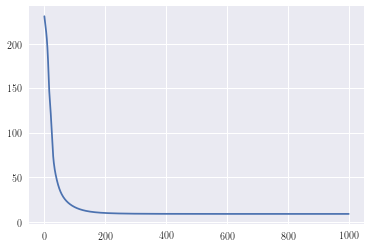

In [58]:
plt.plot(rmses)

In [59]:
hybrid_scores = pd.Series(skater_scores, index=skater_names)
hybrid_scores.sort_values(ascending=False, inplace=True)
hybrid_scores

Yuzuru, HANYU                  1.894050
Nathan, CHEN                   1.803551
Javier, FERNANDEZ              1.790822
Shoma, UNO                     1.789057
Patrick, CHAN                  1.703897
Denis, TEN                     1.696405
Boyang, JIN                    1.610850
Adam, RIPPON                   1.580097
Jason, BROWN                   1.490344
Sergei, VORONOV                1.472533
Takahito, MURA                 1.447655
Alexei, BYCHENKO               1.446761
Mikhail, KOLYADA               1.437773
Max, AARON                     1.429594
Kevin, REYNOLDS                1.406148
Maxim, KOVTUN                  1.403931
Misha, GE                      1.391367
Keiji, TANAKA                  1.386313
Nam, NGUYEN                    1.374465
Alexander, PETROV              1.362922
Jorik, HENDRICKX               1.358675
Moris, KVITELASHVILI           1.335439
Timothy, DOLENSKY              1.333063
Han, YAN                       1.330643
Daniel, SAMOHIN                1.311808


In [60]:
hybrid_ranking, world_ranking = return_ranking(hybrid_scores, world_scores)

In [61]:
calculate_kendall_tau(hybrid_ranking, world_ranking)

There are 239 concordant_pairs out of 276 pairs


0.7318840579710145

### Refactor

In [74]:
class Hybrid(Linear):
    def __init__(self, alpha, lambda_reg=0):
        super().__init__(lambda_reg)
        self.alpha = alpha
        
    def predict_season_scores(self, season_scores):
        broadcasted_skater_scores = self.skater_scores.loc[season_scores['name']].values
        broadcasted_event_scores = self.event_scores.loc[season_scores['event']].values
        self.predicted_season_scores = broadcasted_skater_scores * broadcasted_event_scores + self.baseline
        
    def fit(self, season_scores, n_iter):
        season_table = pd.pivot_table(season_scores[['name', 'event', 'score']], values='score', index='name', columns='event')
        skater_names = list(season_table.index)
        event_names = list(season_table.columns)

        true_scores = season_table.values
        self.skater_scores = np.full(len(skater_names), 0.5)
        self.event_scores = np.full(len(event_names), 0.5)
        self.baseline = 0.5

        self.rmses = []

        for _ in range(n_iter):
            diff = np.outer(self.skater_scores, self.event_scores) + self.baseline - true_scores
            baseline_gradient = np.nansum(diff)
            skater_gradients = np.nansum(diff.T * self.skater_scores, axis=0) + self.lambda_reg * self.skater_scores
            event_gradients = np.nansum(diff * self.event_scores, axis=0) + self.lambda_reg * self.event_scores            
            
            self.baseline = self.baseline - self.alpha * baseline_gradient
            self.skater_scores = self.skater_scores - self.alpha * skater_gradients
            self.event_scores = self.event_scores - self.alpha * event_gradients
            rmse = np.sqrt(np.nanmean(diff**2))
            self.rmses.append(rmse)
            
        self.skater_scores = pd.Series(self.skater_scores, index=skater_names)
        self.event_scores = pd.Series(self.event_scores, index=event_names)
        
        self.skater_scores.sort_values(ascending=False, inplace=True)
        self.event_scores.sort_values(ascending=False, inplace=True)        
        
        self.predict_season_scores(season_scores)

In [102]:
hybrid = Hybrid(alpha=0.0001)
hybrid.fit(season_scores, n_iter=1000)

In [104]:
hybrid.baseline

55.908784359157266

In [81]:
hybrid.skater_scores

Yuzuru, HANYU                  1.894050
Nathan, CHEN                   1.803551
Javier, FERNANDEZ              1.790822
Shoma, UNO                     1.789057
Patrick, CHAN                  1.703897
Denis, TEN                     1.696405
Boyang, JIN                    1.610850
Adam, RIPPON                   1.580097
Jason, BROWN                   1.490344
Sergei, VORONOV                1.472533
Takahito, MURA                 1.447655
Alexei, BYCHENKO               1.446761
Mikhail, KOLYADA               1.437773
Max, AARON                     1.429594
Kevin, REYNOLDS                1.406148
Maxim, KOVTUN                  1.403931
Misha, GE                      1.391367
Keiji, TANAKA                  1.386313
Nam, NGUYEN                    1.374465
Alexander, PETROV              1.362922
Jorik, HENDRICKX               1.358675
Moris, KVITELASHVILI           1.335439
Timothy, DOLENSKY              1.333063
Han, YAN                       1.330643
Daniel, SAMOHIN                1.311808


In [105]:
hybrid.event_scores

EU    136.463848
4C    130.832781
RU    128.192951
CN    128.178315
US    128.003822
FR    125.767991
FN    122.370908
CA    122.042710
JP    120.264202
dtype: float64

In [82]:
hybrid.evaluate_kendall_tau(world_scores)

There are 239 concordant_pairs out of 276 pairs


(0.7318840579710145, 239, 276)

In [83]:
hybrid.evaluate_rmse(season_scores)

8.868465563978589

In [100]:
hybrid_train_eval = hybrid.evaluate_over_years(train_years, season_train, world_train, n_iter=1000)
hybrid_train_eval

,year,rmse,tau,conc,pairs
0,2005,8.631511,0.666667,175,210
1,2006,7.951620,0.628458,206,253
2,2007,7.633914,0.608696,222,276
3,2009,8.185841,0.594203,220,276
4,2010,9.755347,0.696970,196,231
5,2012,8.310617,0.541502,195,253
6,2013,8.938449,0.691700,214,253
7,2014,8.805313,0.828571,192,210
8,2016,11.019698,0.673913,231,276
9,2017,8.868466,0.731884,239,276


In [101]:
hybrid_train_eval['rmse'].mean(), linear_train_eval['rmse'].mean(), loglinear_train_eval['rmse'].mean(), avg_train_eval['rmse'].mean()

(8.810077535097456, 8.779208324854647, 1.043963617896676, 10.087526233651136)

In [99]:
hyrbid_train_eval['tau'].mean(), linear_train_eval['tau'].mean(), loglinear_train_eval['tau'].mean(), avg_train_eval['tau'].mean()

(0.6662563523433088, 0.662111801242236, 0.6627837380011293, 0.6705326557500471)

In [70]:
for lambda_reg in np.arange(0.5, 2.1, 0.1):
    hybrid = Hybrid(lambda_reg=lambda_reg, alpha=0.0001)
    hybrid_train_eval = hybrid.evaluate_over_years(train_years, season_train, world_train, n_iter=1000)
    print(lambda_reg, hybrid_train_eval['rmse'].mean(), hybrid_train_eval['tau'].mean())

0.5 8.811618446776853 0.6662563523433088
0.6 8.81203784343687 0.6662563523433088
0.7 8.812494213174094 0.6669809900244682
0.7999999999999999 8.812987513303364 0.6669809900244682
0.8999999999999999 8.81351770088724 0.6669809900244682
0.9999999999999999 8.814084732742904 0.6685620176924524
1.0999999999999999 8.814688565449144 0.667837380011293
1.1999999999999997 8.815329155353336 0.667837380011293
1.2999999999999998 8.816006458578538 0.667837380011293
1.4 8.816720431030586 0.667837380011293
1.4999999999999998 8.81747102840529 0.667837380011293
1.5999999999999996 8.81825820619563 0.667837380011293
1.6999999999999997 8.819081919699036 0.667837380011293
1.7999999999999998 8.819942124024708 0.667837380011293
1.8999999999999997 8.82083877410097 0.667837380011293
1.9999999999999996 8.821771824682699 0.6670468661773009


In [71]:
for lambda_reg in np.append(np.arange(0.5, 2.1, 0.1), [0]):
    hybrid = Hybrid(lambda_reg=lambda_reg, alpha=0.0001)
    hybrid_train_eval = hybrid.evaluate_over_years(test_years, season_test, world_test, n_iter=1000)
    print(lambda_reg, hybrid_train_eval['rmse'].mean(), hybrid_train_eval['tau'].mean())

0.5 8.771835172968178 0.6051665725578769
0.6 8.772163461487398 0.6051665725578769
0.7 8.772523718784464 0.6051665725578769
0.7999999999999999 8.772915902009178 0.6051665725578769
0.8999999999999999 8.773339967812838 0.6051665725578769
0.9999999999999999 8.773795872351391 0.6051665725578769
1.0999999999999999 8.774283571288585 0.6051665725578769
1.1999999999999997 8.774803019799219 0.6051665725578769
1.2999999999999998 8.775354172572415 0.6051665725578769
1.4 8.775936983814944 0.6051665725578769
1.4999999999999998 8.77655140725462 0.6030020703933747
1.5999999999999996 8.777197396143729 0.6030020703933747
1.6999999999999997 8.777874903262493 0.6051665725578769
1.7999999999999998 8.77858388092263 0.6051665725578769
1.8999999999999997 8.779324280970915 0.6051665725578769
1.9999999999999996 8.78009605479281 0.6051665725578769
0.0 8.77067472651979 0.6051665725578769


In [72]:
avg = AverageScore()
avg_test_eval = avg.evaluate_over_years(test_years, season_test, world_test)
avg_test_eval['tau'].mean()

0.6094955768868812

## Combine models

In [73]:
all_scores = pd.concat([linear_scores, log_linear_scores, hybrid_scores], axis=1, sort=True)
all_scores = all_scores.reindex(world_scores.index).values
all_scores_mean = all_scores.mean(axis=0)
all_scores_std = all_scores.std(axis=0)
all_scores = (all_scores - all_scores_mean) / all_scores_std
all_scores

NameError: name 'linear_scores' is not defined

In [ ]:
from itertools import combinations

In [ ]:
score_diffs = np.array(list(skater1 - skater2 for skater1, skater2 in combinations(all_scores, 2)))

In [ ]:
all_scores

In [ ]:
plt.scatter(all_scores[:, 1], all_scores[:, 2])

In [ ]:
pairwise_status = np.full(len(score_diffs), 1)

In [ ]:
log = BatchLogistic(theta=[0.5, 0.5, 0.5], alpha=0.02)

In [ ]:
log.fit(score_diffs, pairwise_status, n_iter=20000)

In [ ]:
plt.plot(log.avg_log_likelihoods)

In [ ]:
log.theta

In [ ]:
combined_scores = pd.Series(all_scores @ log.theta, index=world_scores.index).sort_values(ascending=False)

In [ ]:
combined_ranking, world_ranking = return_ranking(combined_scores, world_scores)

In [ ]:
calculate_kendall_tau(combined_ranking, world_ranking)